### ペットの画像セグメンテーション  

データセット:Oxford IIIT Pet

コードはこれを参考にしました。  
https://www.kaggle.com/code/dhruv4930/oxford-iiit-pets-segmentation-using-pytorch#Fetch-the-Oxford-IIIT-Pets-dataset-(via-Torchvision)

OxfordIIITPetクラスはtorchvision 0.17以降対応かも  
https://pytorch.org/vision/0.17/generated/torchvision.datasets.OxfordIIITPet.html

In [1]:
import os
import sys

import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import ToTensor, Lambda, Compose, Resize
import torchvision
import matplotlib.pyplot as plt

データの確認

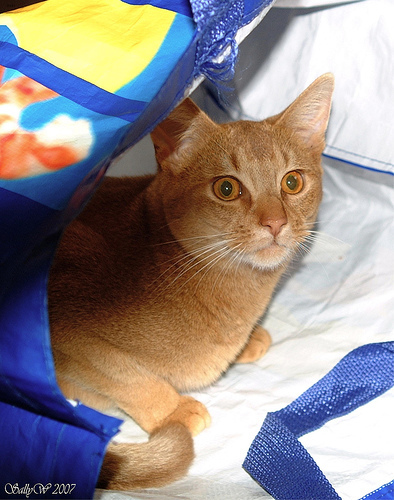

In [2]:
t2img = T.ToPILImage()
img2t = T.ToTensor()

def trimap2f(trimap):
    #1,2,3のラベルマップを0.0~1.0のtensorへ変換
    return (img2t(trimap) * 255.0 - 1) / 2

pets_train_orig = torchvision.datasets.OxfordIIITPet(root="data", split="trainval", target_types="segmentation", download=True)
train_input,train_target = pets_train_orig[0]
train_input

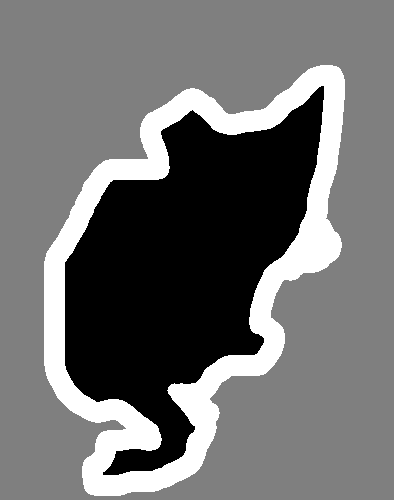

In [3]:
t2img(trimap2f(train_target))

データセットクラス

In [4]:
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [5]:
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    .to(device)を使って入力をgpu等に送る
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={self.device})"

In [6]:
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

device = "cuda" if torch.cuda.is_available() else "cpu"
# 学習時の変換
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(device),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)
# 検証、テスト時の変換
eval_transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(device),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
    ]),
    post_transform=None,
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

In [7]:
pets_train = OxfordIIITPetsAugmented(
    root="data",
    split="trainval",
    target_types="segmentation",
    download=True,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root="data",
    split="test",
    target_types="segmentation",
    download=True,
    **eval_transform_dict,
)

val_size = len(pets_test)//2
valid_indices = list(range(0,val_size))
test_indices = list(range(val_size, len(pets_test)))
valid_data = Subset(pets_test, valid_indices)
test_data = Subset(pets_test, test_indices)
print(len(valid_data), len(test_data))

1834 1835


In [8]:
batch_size = 32

train_dataloader = DataLoader(pets_train, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=1)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 128, 128])
Shape of y:  torch.Size([32, 1, 128, 128]) torch.int64


In [9]:
print("Using {} device".format(device))

class TwoConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size = 3, padding="same")
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.rl = nn.ReLU()
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size = 3, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.TCB1 = TwoConvBlock(3, 64, 64)
        self.TCB2 = TwoConvBlock(64, 128, 128)
        self.TCB3 = TwoConvBlock(128, 256, 256)
        self.TCB4 = TwoConvBlock(256, 512, 512)
        self.TCB5 = TwoConvBlock(512, 1024, 1024)
        self.TCB6 = TwoConvBlock(1024, 512, 512)
        self.TCB7 = TwoConvBlock(512, 256, 256)
        self.TCB8 = TwoConvBlock(256, 128, 128)
        self.TCB9 = TwoConvBlock(128, 64, 64)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        
        self.UC1 = UpConv(1024, 512) 
        self.UC2 = UpConv(512, 256) 
        self.UC3 = UpConv(256, 128) 
        self.UC4= UpConv(128, 64)

        self.conv1 = nn.Conv2d(64, 3, kernel_size = 1)
        self.soft = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.TCB1(x)
        x1 = x
        x = self.maxpool(x)

        x = self.TCB2(x)
        x2 = x
        x = self.maxpool(x)

        x = self.TCB3(x)
        x3 = x
        x = self.maxpool(x)

        x = self.TCB4(x)
        x4 = x
        x = self.maxpool(x)

        x = self.TCB5(x)

        x = self.UC1(x)
        x = torch.cat([x4, x], dim = 1)
        x = self.TCB6(x)

        x = self.UC2(x)
        x = torch.cat([x3, x], dim = 1)
        x = self.TCB7(x)

        x = self.UC3(x)
        x = torch.cat([x2, x], dim = 1)
        x = self.TCB8(x)

        x = self.UC4(x)
        x = torch.cat([x1, x], dim = 1)
        x = self.TCB9(x)

        x = self.conv1(x)
        #x = self.soft(x)

        return x
    
model = UNet_2D().to(device)
#print(model)

Using cuda device


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def calc_metrics(pred, tgt):
    mean_dice_list = []
    mean_acc_list = []
    for i in range(len(pred)):
        present_dice_list = []
        present_acc_list = []
        for c in range(3):
            tgt_mask = F.one_hot(tgt[i], 3)
            pred_mask = torch.argmax(pred[i], dim=0)
            pred_mask = F.one_hot(pred_mask, 3)
            tgt_mask = tgt_mask[:,:,c]
            pred_mask = pred_mask[:,:,c]
            tp = torch.logical_and(tgt_mask, pred_mask).sum().item()
            fp = torch.logical_and(~tgt_mask, pred_mask).sum().item()
            fn = torch.logical_and(tgt_mask, ~pred_mask).sum().item()
            tn = torch.logical_and(~tgt_mask, ~pred_mask).sum().item()
            dice = 2*tp/(2*tp+fp+fn)
            acc = (tp+tn)/(tp+tn+fp+fn)
            present_dice_list.append(dice)
            present_acc_list.append(acc)
        mean_dice_list.append(np.mean(present_dice_list))
        mean_acc_list.append(np.mean(present_acc_list))
    return mean_dice_list, mean_acc_list

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y.squeeze(1))
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 25 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    epoch_loss /= size
    return epoch_loss

In [13]:
def savegrid(img, dirname,filename):
    X_grid = torchvision.utils.make_grid(img)
    X_grid = t2img(X_grid)
    X_grid.save(os.path.join(dirname, filename))

In [14]:
def validation(dataloader, model, t):
    size = len(dataloader.dataset)
    model.eval()
    validation_loss = 0
    dices = []
    accs = []
    img_save_dir = "result/oxfordpet/img"
    os.makedirs(img_save_dir,exist_ok=True)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y.squeeze(1)).item()
            dice_list, acc_list = calc_metrics(pred, y.squeeze(1))
            dices += dice_list
            accs += acc_list
            if batch == 0:
                savegrid(pred.argmax(dim=1,keepdim=True)/2, img_save_dir, f"output_{t+1}.jpg")
                if t == 0:
                    savegrid(X, img_save_dir, "image.jpg")
                    savegrid(y/2, img_save_dir, "target.jpg")
    validation_loss /= size
    mdice = np.mean(dices)
    macc = np.mean(accs)
    print(f"Validation Error: \n mean Dice: {(mdice):.3f}, mean acc: {(macc):.3f}, Avg loss: {validation_loss:>8f} \n")
    return validation_loss

In [15]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss = 0
    best_dice = 0
    worst_dice = 1
    dices = []
    accs = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.squeeze(1)).item()
            dice_list, acc_list = calc_metrics(pred, y.squeeze(1))
            dices += dice_list
            accs += acc_list
            if dice_list[0] > best_dice:
                best_dice = dice_list[0]
                best_sample = (X.cpu(), y.cpu(), pred.cpu())
            if dice_list[0] < worst_dice:
                worst_dice = dice_list[0]
                worst_sample = (X.cpu(), y.cpu(), pred.cpu())
    test_loss /= size
    mdice = np.mean(dices)
    macc = np.mean(accs)
    print(f"Test Error: \n mean Dice: {(mdice):.3f}, mean acc: {(macc):.3f}, Avg loss: {test_loss:>8f} \n")
    print(best_dice)
    return best_sample,worst_sample

In [16]:
epochs = 5
min_loss = 1000
model_path = "model/oxfordpet"
result_dir = "result/oxfordpet"
os.makedirs(model_path, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)
train_losses = []
validation_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    validation_loss = validation(validation_dataloader, model, t)
    validation_losses.append(validation_loss)
    if validation_loss < min_loss:
        best_epoch = t+1
        min_loss = validation_loss
    torch.save(model.state_dict(), os.path.join(result_dir, "model_"+str(t+1)+".pth"))

print(f"best epoch: {best_epoch}")
model = UNet_2D().to(device)
model.load_state_dict(torch.load(os.path.join(result_dir, "model_"+str(best_epoch)+".pth")))
best_sample,worst_sample = test(test_dataloader, model)


Epoch 1
-------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


loss: 1.023285  [    0/ 3680]
loss: 0.737391  [  800/ 3680]
loss: 0.607102  [ 1600/ 3680]
loss: 0.741890  [ 2400/ 3680]
loss: 0.631386  [ 3200/ 3680]
Validation Error: 
 mean Dice: 0.330, mean acc: 0.693, Avg loss: 0.021670 

Epoch 2
-------------------------------
loss: 0.600628  [    0/ 3680]
loss: 0.591244  [  800/ 3680]
loss: 0.594145  [ 1600/ 3680]
loss: 0.558381  [ 2400/ 3680]
loss: 0.495238  [ 3200/ 3680]
Validation Error: 
 mean Dice: 0.396, mean acc: 0.699, Avg loss: 0.015390 

Epoch 3
-------------------------------
loss: 0.493877  [    0/ 3680]
loss: 0.498335  [  800/ 3680]
loss: 0.453214  [ 1600/ 3680]
loss: 0.492916  [ 2400/ 3680]
loss: 0.475793  [ 3200/ 3680]
Validation Error: 
 mean Dice: 0.410, mean acc: 0.701, Avg loss: 0.013522 

Epoch 4
-------------------------------
loss: 0.464459  [    0/ 3680]
loss: 0.387461  [  800/ 3680]
loss: 0.353325  [ 1600/ 3680]
loss: 0.348537  [ 2400/ 3680]
loss: 0.470389  [ 3200/ 3680]
Validation Error: 
 mean Dice: 0.419, mean acc: 0.69

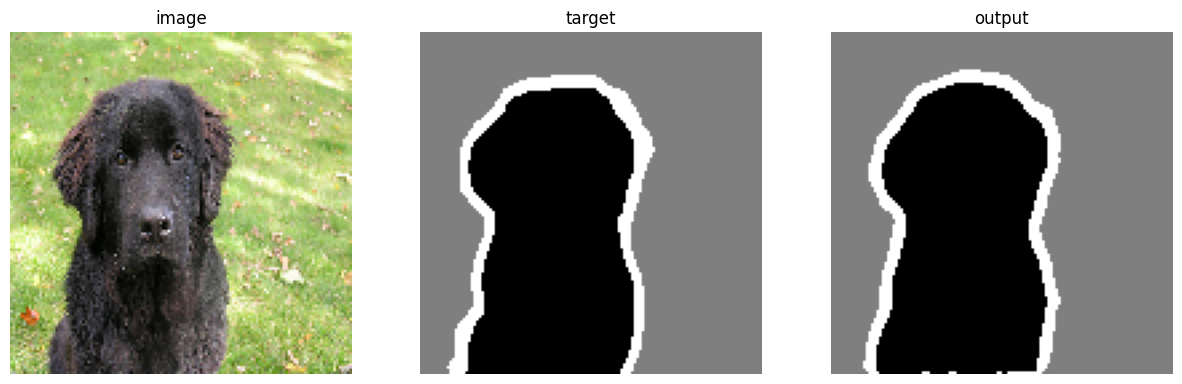

In [17]:
def display_sample(sample):
    image, target, output = sample
    image = t2img(image[0])
    target = t2img(target[0]/2.0) #[0,1]である必要があるが、ラベルが0,1,2なので2で割る
    output = t2img(torch.argmax(output[0],dim=0)/2)
    imgs = [image,target,output]
    titles = ["image","target","output"]
    plt.figure(figsize=(15,5))
    for i, (img,title) in enumerate(zip(imgs,titles)):
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(img,cmap="gray")
        plt.title(title)
        plt.axis("off")

display_sample(best_sample)
#display_sample(worst_sample)


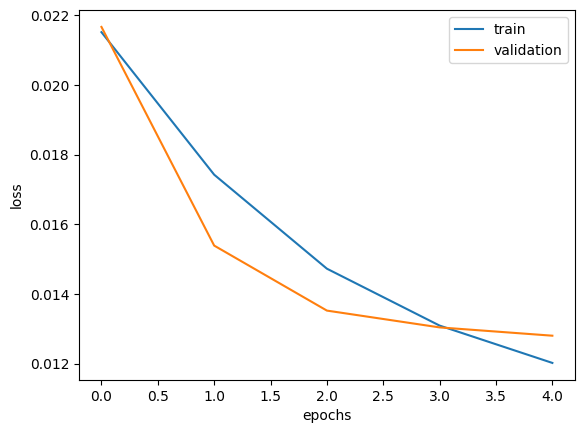

In [18]:
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()